# Apple Iphone's Health app analytics

This notebook allows you to explore analyze the Iphone's health app data. First, export the data from your phone following these steps:

1. On your Iphone, open the Health app.
2. Tap the user profile pic in the top right corner of the app.
3. Scroll down and tap "Export health data".
4. Select the desired app to transfer your health data as a .zip file.
5. Unzip the .zip file in your computer.

After this, just insert the path to the unzipped folder in the variable below and run the notebook.

In [1]:
path = r'C:\Users\Eduardo\Desktop\apple_health_export'

## 1. Modules

In [2]:
import os
import xmltodict
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date
from matplotlib import pyplot as plt

Set graphic options

In [3]:
%matplotlib notebook
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

## 2. Functions and global variables

In [4]:
# Translation to readable metric names
translate = dict(
    HKQuantityTypeIdentifierStepCount                  = 'Step count',
    HKQuantityTypeIdentifierFlightsClimbed             = 'Flights climbed',
    HKQuantityTypeIdentifierEnvironmentalAudioExposure = 'Environmental exposure',
    HKQuantityTypeIdentifierRestingHeartRate           = 'Resting heart rate',
    activeEnergyBurned                                 = 'Active energy burned',
    appleExerciseTime                                  = 'Exercise time',
    appleStandHours                                    = 'Stand hours'
)


def plot_distributions(df, group, metric, order=None):
    '''
    Plots the distributions for a given data metric (metric) 
    across multiple groups defined by input variable (group).
    
    Inputs
    ------
    df     -- dataframe holding the data.
    x      -- grouping variable.
    metric -- metric whose distribution is plotted.
    order  -- order to show the grouping variable groups.
    
    Outputs
    -------
    None
    '''
    
    # Keep only data for the input metric
    df = df.copy().loc[df['@type'] == metric]
    
    # Plot metric distributions and corresponding datapoints
    fig, axes = plt.subplots()
    sns.violinplot(data=df, x=group, y='value', palette='pastel', inner=None, ax=axes, order=order)
    sns.stripplot(data=df, x=group, y='value', alpha=0.15, ax=axes, order=order)
    sns.pointplot(data=df, x=group, y='value', estimator=np.mean, color='black', errorbar=None, ax=axes, order=order)

    # Plot labelling
    axes.set_title(f'Distribution of {translate[metric]} across {group}')
    axes.set_xlabel(group.capitalize())
    axes.set_ylabel(translate[metric].capitalize())
    
    
def plot_daily(df, metric, N=100):
    '''
    Plots the daily time series for a given variable (metric).
    
    Inputs
    ------
    df     -- dataframe holding the data.
    metric -- metric whose time series is plotted.
    N      -- reduction factor for the xticks.
    
    Outputs
    -------
    None
    '''
    
    # Keep only data for the input metric
    df = df.copy().loc[df['@type'] == metric]

    # Plot variables
    x = df['value'].index
    y = df['value'][x]
    labels = df['date'][x]

    # Plot time series
    fig, axes = plt.subplots()
    axes.plot(x, y, color='lightcoral', alpha=0.75)

    # Plot labelling
    axes.set_title(f'Time series of {translate[metric]}')
    axes.set_xlabel('Date')
    axes.set_ylabel(translate[metric].capitalize())
    axes.set_xticks(x[0::N])
    axes.set_xticklabels(labels[0::N], rotation=45);
    plt.subplots_adjust(bottom=0.25)
    

## 3. Import data

In [5]:
# Get XML file path
xml_file_name = os.listdir(path)[0]
xml_file_path = path + f'\{xml_file_name}'

# Open the XML file as df
with open(xml_file_path) as file:
    dict_xml   = xmltodict.parse(file.read())
    df_xml     = pd.DataFrame.from_dict(dict_xml)['HealthData']
    df_records = pd.DataFrame(df_xml['Record'])
    df_workout = pd.DataFrame(df_xml['Workout'])
    df_summary = pd.DataFrame(df_xml['ActivitySummary'])

## 4. Iphone analysis
This section of the code explores the main metrics from the *df_records* registered by the iPhone, which include the step count and the flights climbed. In this first cell, we preprocess the imported data to obtain the aggregated metrics per day and create new useful columns.

In [6]:
# Use only iPhone data and desired metrics
metrics   = ['HKQuantityTypeIdentifier' + x for x in ['StepCount', 'FlightsClimbed']]
df_iphone = df_records.copy().loc[(df_records['@type'].isin(metrics)) & (df_records['@sourceName'] == 'iPhone')]
df_iphone = df_iphone.reset_index(drop=True)

# Convert value column from string to numeric
df_iphone['@value'] = pd.to_numeric(arg=df_iphone['@value'], downcast='integer')

# Create a date column and aggregate metrics by day
date_col = df_iphone['@creationDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S %z').date())
df_iphone.insert(loc=1, column='date', value=date_col)
df_iphone = df_iphone.groupby(['date', '@type'])['@value'].sum().reset_index(name='value')

# Create a year column
df_iphone.insert(loc=1, column='year', value=df_iphone['date'].apply(lambda x: x.year))

# Create a weekday column
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
df_iphone.insert(loc=2, column='weekday', value=df_iphone['date'].apply(lambda x: weekdays[x.weekday()]))

# Show data
df_iphone.head()

,date,year,weekday,@type,value
0,2018-09-19,2018,Wednesday,HKQuantityTypeIdentifierStepCount,2911.0
1,2018-09-20,2018,Thursday,HKQuantityTypeIdentifierFlightsClimbed,2.0
2,2018-09-20,2018,Thursday,HKQuantityTypeIdentifierStepCount,1599.0
3,2018-09-21,2018,Friday,HKQuantityTypeIdentifierFlightsClimbed,3.0
4,2018-09-21,2018,Friday,HKQuantityTypeIdentifierStepCount,10814.0


### 4.1. Steps

Daily step count

<IPython.core.display.Javascript object>


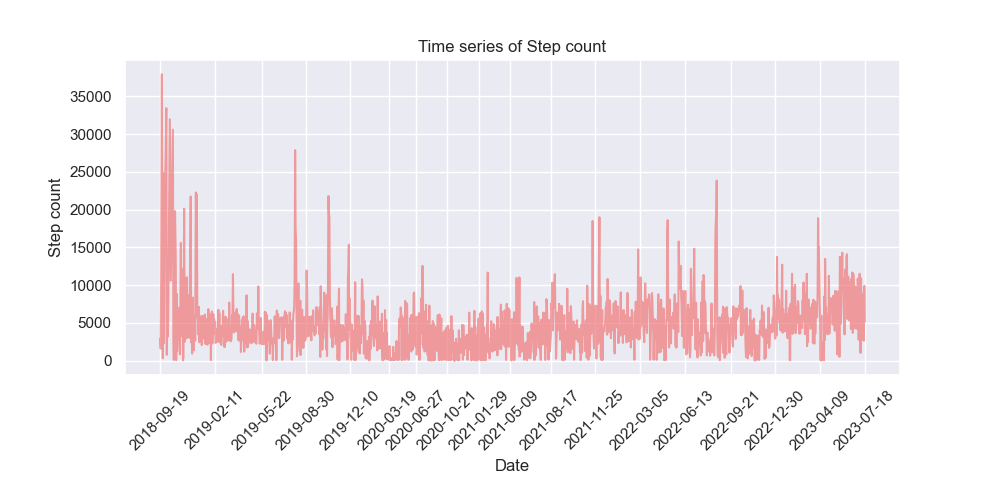

In [17]:
plot_daily(df=df_iphone, metric='HKQuantityTypeIdentifierStepCount')

Step distribution per week day

<IPython.core.display.Javascript object>


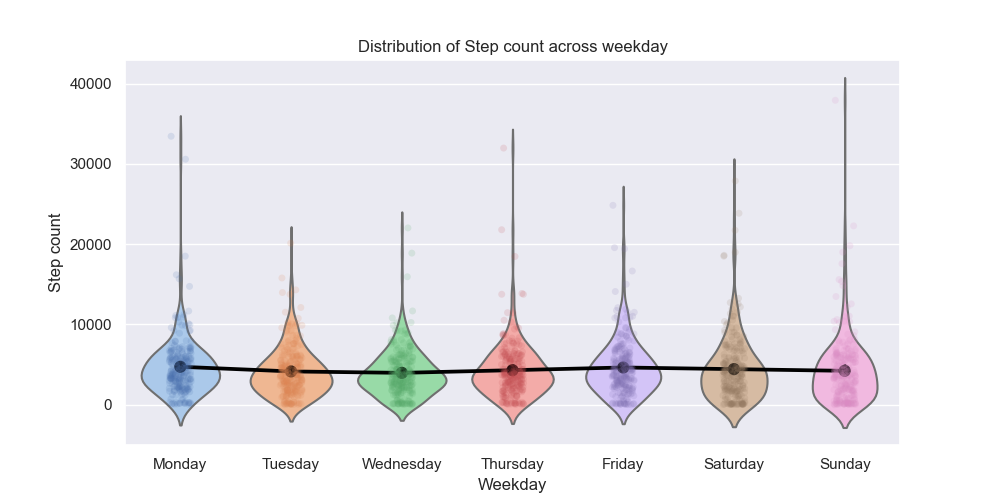

In [18]:
plot_distributions(df=df_iphone, group='weekday', metric='HKQuantityTypeIdentifierStepCount', order=weekdays)

Step distribution per year

<IPython.core.display.Javascript object>


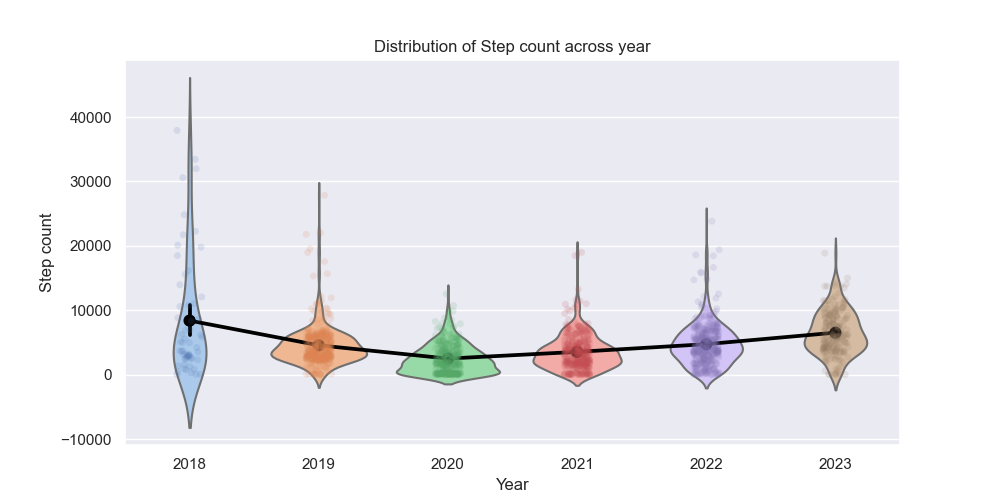

In [19]:
plot_distributions(df=df_iphone, group='year', metric='HKQuantityTypeIdentifierStepCount')

### 4.2. Flights climbed

Daily flights climbed

<IPython.core.display.Javascript object>


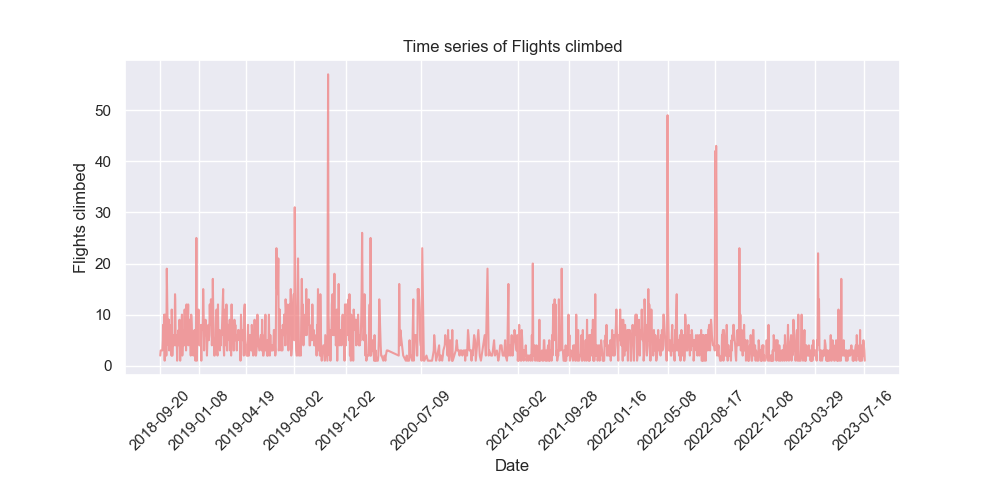

In [20]:
plot_daily(df=df_iphone, metric='HKQuantityTypeIdentifierFlightsClimbed')

Flights climbed distribution per weekday

<IPython.core.display.Javascript object>


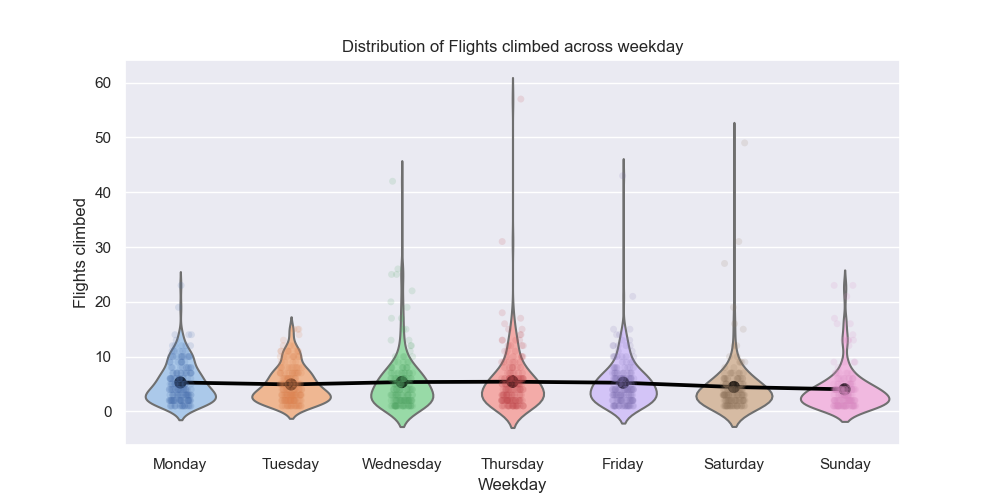

In [21]:
plot_distributions(df=df_iphone, group='weekday', metric='HKQuantityTypeIdentifierFlightsClimbed', order=weekdays)

Flights climbed distribution per year

<IPython.core.display.Javascript object>


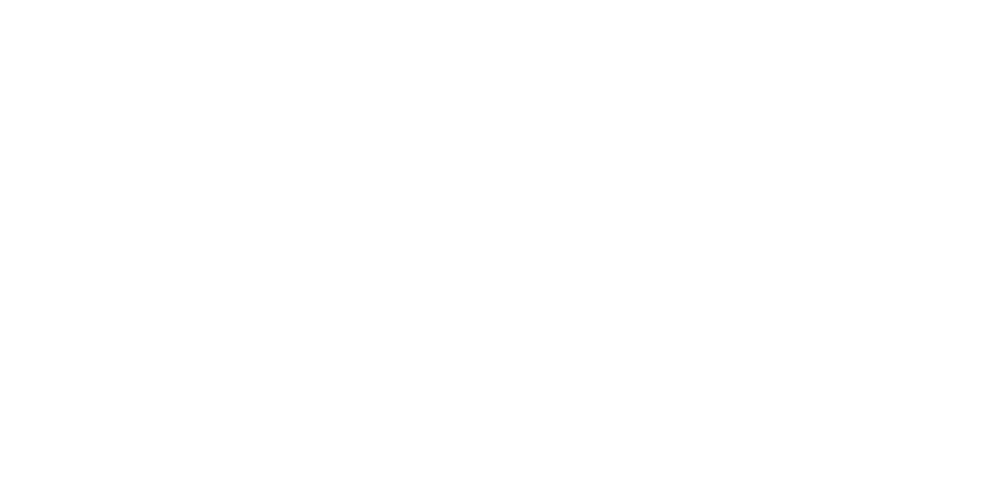

In [12]:
plot_distributions(df=df_iphone, group='year', metric='HKQuantityTypeIdentifierFlightsClimbed')

## 5. Apple Watch analysis

In this code section, we analyze the data from the Apple Watch. First, we examine activity data, which here includes resting heart rate and environmental audio exposure. In this first cell, we preprocess the data.

In [13]:
# Use only Apple Watch data and desired metrics
metrics  = ['HKQuantityTypeIdentifier' + x for x in ['RestingHeartRate', 'EnvironmentalAudioExposure']]
df_watch = df_records.copy().loc[df_records['@sourceName'].str.contains('Watch')]
df_watch = df_records.copy().loc[(df_records['@type'].isin(metrics))].reset_index(drop=True)

# Convert value column from string to numeric
df_watch['@value'] = pd.to_numeric(arg=df_watch['@value'], downcast='integer')
df_watch.rename(columns={'@value': 'value'}, inplace=True)

# Create a date column
date_col = df_watch['@creationDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S %z').date())
df_watch.insert(loc=1, column='date', value=date_col)

# Create weekday and year column
df_watch.insert(loc=1, column='year', value=df_watch['date'].apply(lambda x: x.year))
df_watch.insert(loc=2, column='weekday', value=df_watch['date'].apply(lambda x: weekdays[x.weekday()]))

# Show data
df_watch.head()

,@type,year,weekday,date,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,value,MetadataEntry,@device,HeartRateVariabilityMetadataList
0,HKQuantityTypeIdentifierRestingHeartRate,2022,Friday,2022-10-07,Apple Watch de Eduardo,9.0,count/min,2022-10-07 23:44:36 +0200,2022-10-07 18:38:23 +0200,2022-10-07 23:39:42 +0200,76.0,NaN,NaN,NaN
1,HKQuantityTypeIdentifierRestingHeartRate,2022,Saturday,2022-10-08,Apple Watch de Eduardo,9.0,count/min,2022-10-08 18:21:29 +0200,2022-10-08 00:00:39 +0200,2022-10-08 18:17:35 +0200,54.0,NaN,NaN,NaN
2,HKQuantityTypeIdentifierRestingHeartRate,2022,Sunday,2022-10-09,Apple Watch de Eduardo,9.0,count/min,2022-10-09 23:15:22 +0200,2022-10-09 05:55:10 +0200,2022-10-09 23:12:16 +0200,55.0,NaN,NaN,NaN
3,HKQuantityTypeIdentifierRestingHeartRate,2022,Tuesday,2022-10-11,Apple Watch de Eduardo,9.0.2,count/min,2022-10-11 08:23:18 +0200,2022-10-10 00:00:42 +0200,2022-10-10 23:06:53 +0200,58.0,NaN,NaN,NaN
4,HKQuantityTypeIdentifierRestingHeartRate,2022,Tuesday,2022-10-11,Apple Watch de Eduardo,9.0.2,count/min,2022-10-11 19:53:44 +0200,2022-10-11 08:28:54 +0200,2022-10-11 19:47:40 +0200,60.0,NaN,NaN,NaN


### 5.1. Environmental exposure

Daily environmental exposure and times the audio threshold was exceeded.

<IPython.core.display.Javascript object>


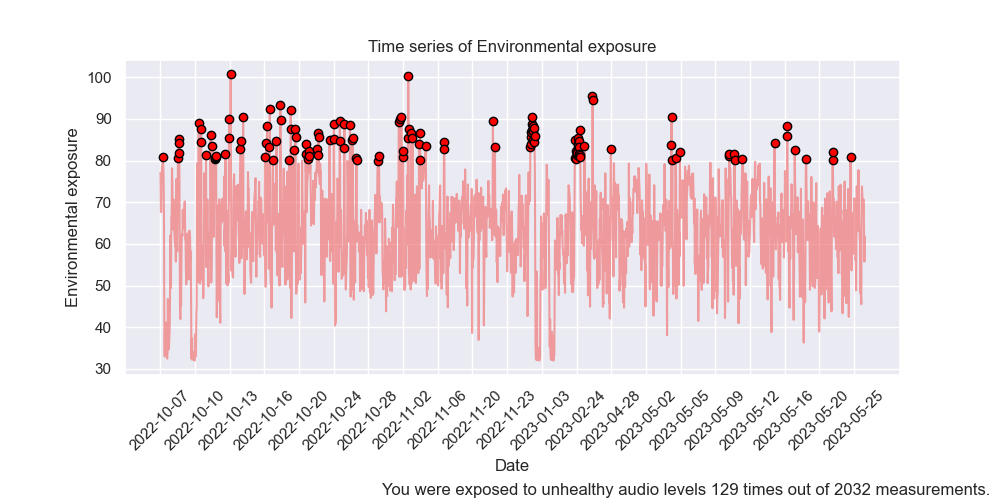

Text(0.99, 0.01, 'You were exposed to unhealthy audio levels 129 times out of 2032 measurements.')

In [23]:
plot_daily(df=df_watch, metric='HKQuantityTypeIdentifierEnvironmentalAudioExposure', N=100)

# Find unhealthy levels
axes = plt.gca()
x, y = axes.lines[0].get_data()
mask = y > 80

# Overlap unhealthy levels to the plot
axes.plot(x[mask], y[mask], marker='o', linestyle='None', markerfacecolor='red', markeredgecolor='black')

# Footnote
plt.figtext(x=0.99, y=0.01, s=f'You were exposed to unhealthy audio levels {sum(mask)} times out of {len(mask)} measurements.', horizontalalignment='right')

### 5.2. Resting heart rate

Daily resting heart rate and times the healthy heart rate threshold was exceeded.

<IPython.core.display.Javascript object>


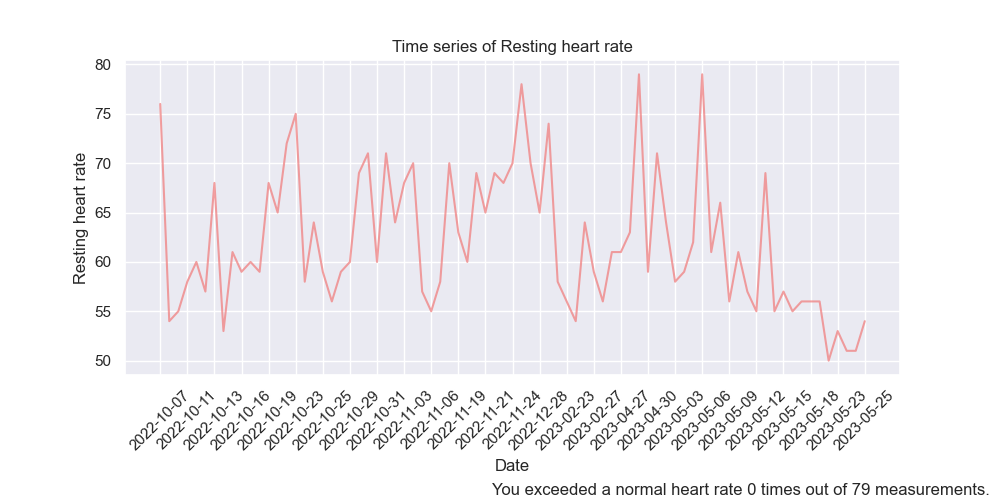

Text(0.99, 0.01, 'You exceeded a normal heart rate 0 times out of 79 measurements.')

In [24]:
plot_daily(df=df_watch, metric='HKQuantityTypeIdentifierRestingHeartRate', N=3)

# Find heart rates over threshold
axes = plt.gca()
x, y = axes.lines[0].get_data()
mask = y > 100

# Overlap unhealthy levels to the plot
axes.plot(x[mask], y[mask], marker='o', linestyle='None', markerfacecolor='red', markeredgecolor='black')

# Footnote
plt.figtext(x=0.99, y=0.01, s=f'You exceeded a normal heart rate {sum(mask)} times out of {len(mask)} measurements.', horizontalalignment='right')

### 5.3. Activity analysis

Daily activity goals registered by the Apple Watch (energy burned, exercise time and stand hours) and corresponding performance.

<IPython.core.display.Javascript object>


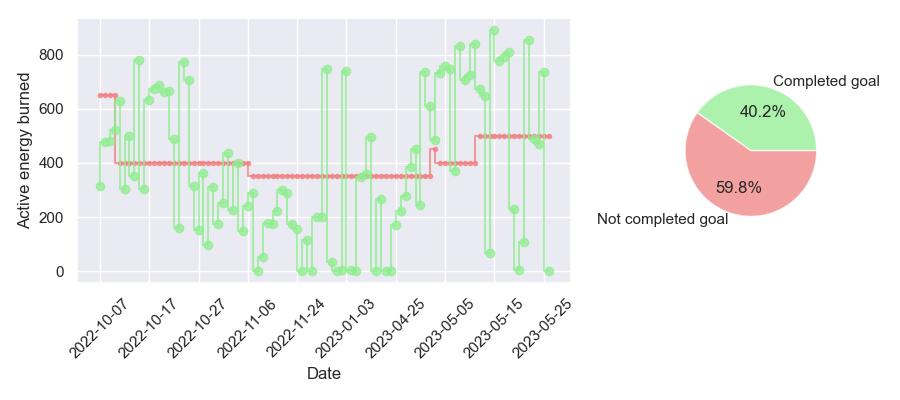

<IPython.core.display.Javascript object>


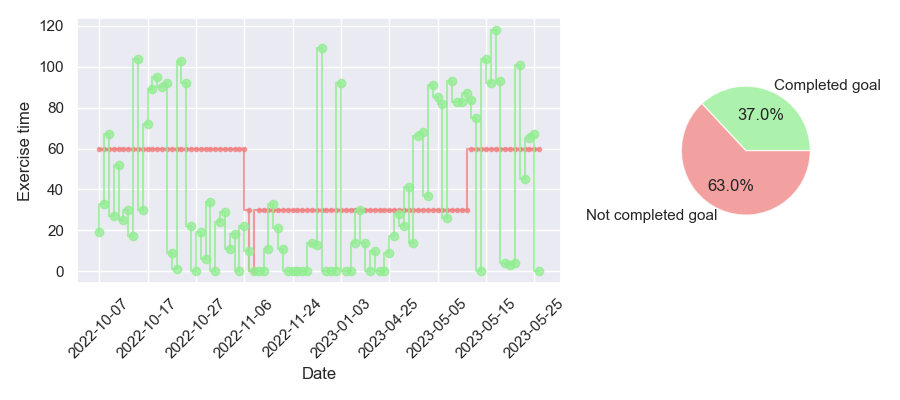

<IPython.core.display.Javascript object>


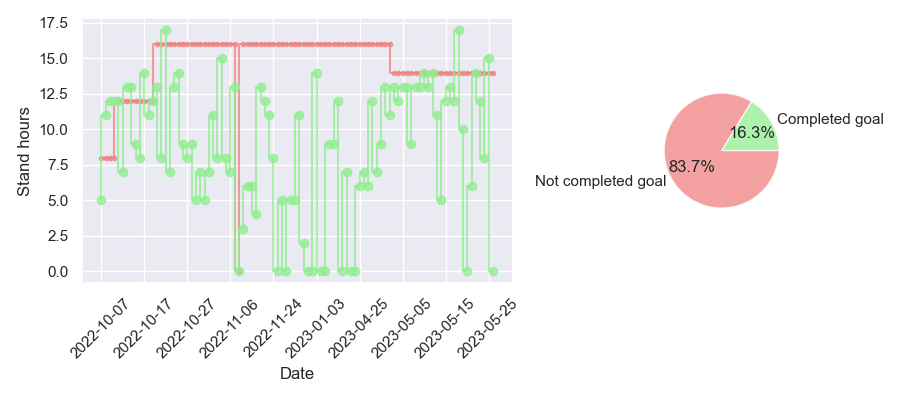

In [25]:
# Convert data columns from string to numeric
for col in [x for x in df_summary.columns if not any(word in x.lower() for word in ("date", "unit"))]:
    df_summary[col] = pd.to_numeric(arg=df_summary[col], downcast='integer')
            
# Activity columns
activities = ['@activeEnergyBurned', '@appleExerciseTime', '@appleStandHours']

# Factor to reduce label density
N = 10

# Plot programatically
for activity in activities:
    
    # Create figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), width_ratios=[3, 1])
    
    # Variables
    goal   = activity + 'Goal'
    x1, y1 = df_summary['@dateComponents'].index, df_summary[goal].values
    x2, y2 = df_summary['@dateComponents'].index, df_summary[activity].values
    labels = df_summary['@dateComponents'].values
    
    # Goals vs performance
    axes[0].plot(x1, y1, marker='.', drawstyle='steps', color='lightcoral', alpha=0.75)
    axes[0].plot(x2, y2, marker='o', drawstyle='steps', color='lightgreen', alpha=0.75)
    axes[0].set_ylabel(translate[activity.split('@')[1]].capitalize())
    axes[0].set_xlabel('Date')
    axes[0].set_xticks(x1[0::N])
    axes[0].set_xticklabels(labels[0::N], rotation=45);
    
    # Completed goal pie chart
    completed = [np.sum(df_summary[activity] >= df_summary[goal]), np.sum(df_summary[activity] < df_summary[goal])]
    axes[1].pie(
        x=completed, 
        labels=['Completed goal', 'Not completed goal'], 
        autopct='%1.1f%%', 
        colors=['lightgreen', 'lightcoral'], 
        wedgeprops={"alpha": 0.75}
    )
    
    # Adjust figure
    plt.tight_layout()
    